# libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize, stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import PanelOLS
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# data import

In [2]:
# Example usage:
panel_data = pd.read_csv('models_data/geminis.csv')
gemini_groups = pd.read_csv('outputs/gemini_groups/gemini_groups_economic2vec.csv')

# covariates for gdp growth modeling

In [33]:
# 2. Define covariates
covariates = [
    # 'gdp_per_capita_growth_annual_share', 
    # 'gross_capital_formation_share_of_gdp', 
    # 'gross_fixed_capital_formation_share_of_gdp', 
    # 'urban_population_growth_annual_share', 
    # 'methane_emissions_share_change_from_1990'

    # 'industry_including_construction_value_added_annual_share_growth', 
    # 'exports_of_goods_and_services_annual_share_growth', 
    # 'population_growth_annual_share', 
    # 'methane_emissions_share_change_from_1990', 
    # 'total_greenhouse_gas_emissions_share_change_from_1990'

    # 'industry_including_construction_value_added_annual_share_growth', 
    # 'exports_of_goods_and_services_annual_share_growth', 
    # 'population_growth_annual_share', 
    # 'urban_population_growth_annual_share', 
    # 'total_greenhouse_gas_emissions_share_change_from_1990'

    'industry_including_construction_value_added_annual_share_growth', 
    'exports_of_goods_and_services_annual_share_growth', 
    'gross_capital_formation_annual_share_growth', 
    'population_growth_annual_share',  
    'total_greenhouse_gas_emissions_share_change_from_1990'
]

# function to clean and validate data

In [49]:
def clean_and_validate_panel(panel_data, covariates, outcome_var='gdp_growth_annual_share'):
    """Clean panel data and validate its structure"""
    panel = panel_data.copy()
    
    # 1. Convert numeric columns
    numeric_cols = covariates + [outcome_var, 'year', 'has_platform']
    for col in numeric_cols:
        panel[col] = pd.to_numeric(panel[col], errors='coerce')
    
    # 2. Handle duplicates (keep first instance)
    duplicates = panel.groupby(['country', 'year']).size()
    if (duplicates > 1).any():
        print("Removing duplicate entries for:")
        print(duplicates[duplicates > 1])
        panel = panel.drop_duplicates(['country', 'year'])
    
    # 3. Sort and reset index
    panel = panel.sort_values(['country', 'year']).reset_index(drop=True)
    
    # 4. Validate panel structure
    years_per_country = panel.groupby('country')['year'].nunique()
    if not (years_per_country == years_per_country.iloc[0]).all():
        print("\nWarning: Unbalanced panel - years per country:")
        print(years_per_country[years_per_country != years_per_country.mode()[0]])
    
    return panel

In [50]:
def prepare_analysis_data(panel_data, gemini_groups, covariates, outcome_var='gdp_growth_annual_share'):
    """Prepare complete dataset for analysis"""
    # 1. Clean panel data
    clean_panel = clean_and_validate_panel(panel_data, covariates, outcome_var)
    
    # 2. Merge with control groups
    merged = pd.merge(
        clean_panel,
        gemini_groups[['Country', 'Gemini', 'Similarity_Score']],
        left_on='country',
        right_on='Country',
        how='left'
    ).drop('Country', axis=1)
    
    # 3. Get treatment timing
    treatment_periods = (
        merged[merged['has_platform'] == 1]
        .groupby('country')['year']
        .min()
        .astype(int)
    )
    
    # 4. Get additional metadata
    treated_units = treatment_periods.index.tolist()
    years_range = merged['year'].max() - merged['year'].min() + 1
    
    # 5. Print summary statistics
    print("\nData Summary:")
    print(f"Time period: {merged['year'].min()} - {merged['year'].max()} ({years_range} years)")
    print(f"Number of countries: {merged['country'].nunique()}")
    print(f"Number of treated units: {len(treated_units)}")
    
    return {
        'data': merged,
        'treatment_periods': treatment_periods,
        'treated_units': treated_units,
        'years_range': years_range
    }

In [51]:
def verify_control_matches(data, treated_units):
    """Verify control group matching"""
    missing_controls = []
    for unit in treated_units:
        control = data[data['country'] == unit]['Gemini'].iloc[0]
        if control not in data['country'].unique():
            missing_controls.append((unit, control))
    
    if missing_controls:
        print("\nWarning: Missing control units:")
        for unit, control in missing_controls:
            print(f"{unit} -> {control}")
    
    return len(missing_controls) == 0

## check the functions outputs

In [34]:
# 3. Run the preparation process
clean_data = clean_and_validate_panel(panel_data, covariates)

Removing duplicate entries for:
country  year  
Russia   2017.0    2
         2018.0    2
dtype: int64


In [35]:
# 4. Prepare full dataset
analysis_data = prepare_analysis_data(clean_data, gemini_groups, covariates)


Data Summary:
Time period: 1991.0 - 2022.0 (32.0 years)
Number of countries: 217
Number of treated units: 23


In [36]:
# 5. Verify control matches
verify_control_matches(analysis_data['data'], analysis_data['treated_units'])

True

In [37]:
# Access the prepared data
data = analysis_data['data']  # The main cleaned and merged dataset
treatment_periods = analysis_data['treatment_periods']  # When each country got treatment
treated_units = analysis_data['treated_units']  # List of treated countries

In [38]:
data[data['has_platform'] == 1]\
    .groupby('country')['year']\
    .min()

country
Argentina               1999.0
Brazil                  1991.0
Chile                   1991.0
China                   1998.0
Colombia                2015.0
Germany                 2011.0
India                   2007.0
Indonesia               2009.0
Japan                   1996.0
Kenya                   1997.0
Korea                   1999.0
Mexico                  1991.0
Netherlands             1996.0
Nigeria                 2012.0
Russia                  2017.0
Saudi Arabia            2005.0
Singapore               2009.0
South Africa            1991.0
Spain                   2015.0
Sweden                  2006.0
Thailand                1991.0
United Arab Emirates    2012.0
United States           1998.0
Name: year, dtype: float64

In [39]:
# Example: Look at data for a specific country
country_data = data[data['country'] == 'Germany']
print("\nExample data for Germany:")
print(country_data[['year', 'has_platform', 'gdp_growth_annual_share']].head())


Example data for Germany:
        year  has_platform  gdp_growth_annual_share
2304  1991.0           0.0                 5.108262
2305  1992.0           0.0                 1.923077
2306  1993.0           0.0                -0.976850
2307  1994.0           0.0                 2.391892
2308  1995.0           0.0                 1.544146


In [40]:
# Example: Get treatment year for a country
if 'Germany' in treatment_periods:
    print(f"\nGermany's treatment year: {treatment_periods['Germany']}")


Germany's treatment year: 2011


# calculate ATE

In [41]:
def calculate_unit_effects(data, unit, synthetic_control, treatment_year, covariates, outcome_var):
    """Calculate treatment effects using robust panel methods"""
    try:
        # Get treated and control data
        treated_data = data[data['country'] == unit].copy()
        control_data = data[data['country'] == synthetic_control].copy()
        
        # Print diagnostic information
        print(f"\nProcessing country: {unit}")
        print(f"Treatment year: {treatment_year}")
        print(f"Control unit: {synthetic_control}")
        
        # Split into pre and post periods
        pre_treated = treated_data[treated_data['year'] < treatment_year]
        post_treated = treated_data[treated_data['year'] >= treatment_year]
        pre_control = control_data[control_data['year'] < treatment_year]
        post_control = control_data[control_data['year'] >= treatment_year]
        
        n_pre_treated = len(pre_treated)
        n_post_treated = len(post_treated)
        n_pre_control = len(pre_control)
        n_post_control = len(post_control)
        
        print(f"Treated unit observations - Pre: {n_pre_treated}, Post: {n_post_treated}")
        print(f"Control unit observations - Pre: {n_pre_control}, Post: {n_post_control}")
        
        # Check for sufficient observations
        if n_pre_treated < 2 or n_pre_control < 2:
            print("Warning: Insufficient pre-treatment periods")
            return None
            
        # Calculate simple DiD
        treat_pre = pre_treated[outcome_var].mean()
        treat_post = post_treated[outcome_var].mean()
        control_pre = pre_control[outcome_var].mean()
        control_post = post_control[outcome_var].mean()
        
        simple_did = (treat_post - treat_pre) - (control_post - control_pre)
        print(f"Simple DiD estimate: {simple_did:.4f}")
        
        # Prepare panel data
        all_data = pd.concat([treated_data, control_data])
        all_data['post'] = (all_data['year'] >= treatment_year).astype(int)
        all_data['treated'] = (all_data['country'] == unit).astype(int)
        all_data['did'] = all_data['post'] * all_data['treated']
        
        # Create panel structure
        panel_data = all_data.set_index(['country', 'year'])
        
        # Run panel regression with robust standard errors
        
        model = PanelOLS(
            dependent=panel_data[outcome_var],
            exog=panel_data[['did'] + covariates],
            entity_effects=True
            # time_effects=True #new
        )
        
        # Use both HC3 robust errors and clustered errors
        results_robust = model.fit(
            cov_type='kernel'
            # cov_type='clustered', #new
            # cluster_entity=True #new
        )
        
        # Extract results
        did_effect = results_robust.params['did']
        did_se = results_robust.std_errors['did']
        t_stat = results_robust.tstats['did']
        p_value = results_robust.pvalues['did']
        conf_int = results_robust.conf_int().loc['did']
        
        print(f"Panel DiD estimate: {did_effect:.4f}")
        print(f"Standard error: {did_se:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        return {
            'effect_size': did_effect,
            't_statistic': t_stat,
            'p_value': p_value,
            'ci_lower': conf_int.iloc[0],
            'ci_upper': conf_int.iloc[1],
            'n_pre': n_pre_treated + n_pre_control,
            'n_post': n_post_treated + n_post_control,
            'se': did_se,
            'simple_did': simple_did,
            'treat_pre_mean': treat_pre,
            'treat_post_mean': treat_post,
            'control_pre_mean': control_pre,
            'control_post_mean': control_post,
            'r2': results_robust.rsquared
        }
        
    except Exception as e:
        print(f"Error in effect calculation: {str(e)}")
        return None

## function to run the pipeline

In [42]:
def run_analysis(panel_data, gemini_groups, covariates, outcome_var='gdp_growth_annual_share'):
    """Run complete DiD analysis with proper error handling"""
    # Get treatment periods
    treatment_periods = panel_data[panel_data['has_platform'] == 1].groupby('country')['year'].min()
    
    # Get synthetic controls
    controls = pd.Series(gemini_groups.set_index('Country')['Gemini'])
    
    country_effects = {}
    
    for country in treatment_periods.index:
        if country in controls.index:
            result = calculate_unit_effects(
                panel_data,
                country,
                controls[country],
                treatment_periods[country],
                covariates,
                outcome_var
            )
            if result is not None:
                country_effects[country] = result
    
    # Calculate average effect
    if country_effects:
        effects = []
        std_errs = []
        
        for result in country_effects.values():
            if result['se'] > 0:  # Only include results with valid standard errors
                effects.append(result['effect_size'])
                std_errs.append(result['se'])
        
        if effects:
            effects = np.array(effects)
            std_errs = np.array(std_errs)
            
            # Inverse variance weighting
            weights = 1 / (std_errs ** 2)
            weights = weights / weights.sum()
            
            avg_effect = np.average(effects, weights=weights)
            avg_se = np.sqrt(1 / np.sum(1 / (std_errs ** 2)))
            
            average_effect = {
                'effect': avg_effect,
                'std_err': avg_se,
                'ci_lower': avg_effect - 1.96 * avg_se,
                'ci_upper': avg_effect + 1.96 * avg_se,
                'p_value': 2 * (1 - stats.norm.cdf(abs(avg_effect / avg_se))),
                'n_included': len(effects)
            }
        else:
            average_effect = None
    else:
        average_effect = None
    
    return {
        'country_effects': country_effects,
        'average_effect': average_effect,
        'n_total': len(treatment_periods),
        'n_valid': len(country_effects)
    }

# results

In [43]:
# Run analysis
results = run_analysis(panel_data, gemini_groups, covariates)


Processing country: Argentina
Treatment year: 1999.0
Control unit: Uruguay
Treated unit observations - Pre: 8, Post: 24
Control unit observations - Pre: 8, Post: 24
Simple DiD estimate: -1.3631
Panel DiD estimate: -0.6692
Standard error: 1.0522
P-value: 0.5274

Processing country: Brazil
Treatment year: 1991.0
Control unit: Colombia
Treated unit observations - Pre: 0, Post: 32
Control unit observations - Pre: 0, Post: 32

Processing country: Chile
Treatment year: 1991.0
Control unit: Australia
Treated unit observations - Pre: 0, Post: 32
Control unit observations - Pre: 0, Post: 32

Processing country: China
Treatment year: 1998.0
Control unit: Thailand
Treated unit observations - Pre: 7, Post: 25
Control unit observations - Pre: 7, Post: 25
Simple DiD estimate: 0.1699
Panel DiD estimate: 1.7122
Standard error: 0.8421
P-value: 0.0468

Processing country: Colombia
Treatment year: 2015.0
Control unit: Ecuador
Treated unit observations - Pre: 24, Post: 8
Control unit observations - Pre: 

In [44]:
# Print summary
print("\nAnalysis Summary:")
print(f"Total countries analyzed: {results['n_total']}")
print(f"Valid estimations: {results['n_valid']}")

if results['average_effect']:
    ae = results['average_effect']
    print("\nAverage Treatment Effect:")
    print(f"Effect: {ae['effect']:.4f}")
    print(f"Standard Error: {ae['std_err']:.4f}")
    print(f"95% CI: [{ae['ci_lower']:.4f}, {ae['ci_upper']:.4f}]")
    print(f"P-value: {ae['p_value']:.4f}")
    print(f"Based on {ae['n_included']} countries")

# Print individual results
for country, effects in results['country_effects'].items():
    print(f"\nResults for {country}:")
    print(f"Simple DiD: {effects['simple_did']:.4f}")
    print(f"Panel DiD: {effects['effect_size']:.4f}")
    print(f"P-value: {effects['p_value']:.4f}")
    print(f"95% CI: [{effects['ci_lower']:.4f}, {effects['ci_upper']:.4f}]")


Analysis Summary:
Total countries analyzed: 23
Valid estimations: 18

Average Treatment Effect:
Effect: 0.5884
Standard Error: 0.1211
95% CI: [0.3511, 0.8257]
P-value: 0.0000
Based on 18 countries

Results for Argentina:
Simple DiD: -1.3631
Panel DiD: -0.6692
P-value: 0.5274
95% CI: [-2.7771, 1.4386]

Results for China:
Simple DiD: 0.1699
Panel DiD: 1.7122
P-value: 0.0468
95% CI: [0.0253, 3.3991]

Results for Colombia:
Simple DiD: 2.4812
Panel DiD: -0.2218
P-value: 0.7743
95% CI: [-1.7637, 1.3202]

Results for Germany:
Simple DiD: 0.7283
Panel DiD: 1.7451
P-value: 0.0000
95% CI: [0.9833, 2.5068]

Results for India:
Simple DiD: 0.7411
Panel DiD: 0.8874
P-value: 0.1186
95% CI: [-0.2342, 2.0090]

Results for Indonesia:
Simple DiD: 1.3192
Panel DiD: 0.4109
P-value: 0.5529
95% CI: [-0.9677, 1.7894]

Results for Japan:
Simple DiD: 3.6586
Panel DiD: 0.6526
P-value: 0.1024
95% CI: [-0.1348, 1.4401]

Results for Kenya:
Simple DiD: -1.5157
Panel DiD: 0.9024
P-value: 0.1897
95% CI: [-0.4592, 2.2

# functions for plotting

## plot outline

### old

In [45]:
# def plot_treatment_visualization(analysis_results, data, treatment_periods, gemini_groups, covariates):
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
#     _plot_trends(axes[0, 0], data, treatment_periods)
#     _plot_cumulative_effect(axes[0, 1], data, treatment_periods, analysis_results, covariates, gemini_groups)
#     _plot_country_effects(axes[1, 0], analysis_results)
#     _plot_prepost_comparison(axes[1, 1], analysis_results)
    
#     plt.tight_layout()
#     return fig

### new

In [16]:
# Modified version of plot_treatment_visualization to use this function
def plot_treatment_visualization(analysis_results, data, treatment_periods, gemini_groups):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    _plot_trends(axes[0, 0], data, treatment_periods)
    plot_cumulative_effect_standalone(data, treatment_periods, analysis_results, gemini_groups, ax=axes[0, 1])
    _plot_country_effects(axes[1, 0], analysis_results)
    _plot_prepost_comparison(axes[1, 1], analysis_results)
    
    plt.tight_layout()
    return fig

## overall average trends

In [17]:
def _plot_trends(ax, data, treatment_periods):
    """Plot actual treated and counterfactual trends"""
    years = sorted(data['year'].unique())
    treated_means = []
    control_means = []
    
    for year in years:
        treated_countries = [c for c, t in treatment_periods.items() if t <= year]
        treated_val = data[
            (data['country'].isin(treated_countries)) & 
            (data['year'] == year)
        ]['gdp_growth_annual_share'].mean()
        
        control_val = data[
            (~data['country'].isin(treated_countries)) & 
            (data['year'] == year)
        ]['gdp_growth_annual_share'].mean()
        
        if not (np.isnan(treated_val) or np.isnan(control_val)):
            treated_means.append(treated_val)
            control_means.append(control_val)
    
    plot_years = years[-len(treated_means):]
    ax.plot(plot_years, treated_means, 'b-', label='Treated')
    ax.plot(plot_years, control_means, 'r--', label='Counterfactual')
    
    ax.set_xlabel('Year')
    ax.set_ylabel('GDP Growth Annual Share')
    ax.set_title('Treated and Counterfactual Trends')
    ax.legend()
    ax.grid(True, alpha=0.3)

### cumuilative effect in time

#### new

In [47]:
def plot_cumulative_effect_standalone(data, treatment_periods, analysis_results, gemini_groups, ax=None):
    """
    Standalone version of plot_cumulative_effect that can be run independently
    
    Parameters:
    -----------
    data : pandas DataFrame
        The main dataset
    treatment_periods : dict or Series
        Mapping of countries to their treatment periods
    analysis_results : dict
        Results from the DiD analysis
    gemini_groups : pandas DataFrame
        Mapping of treated countries to their synthetic controls
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, creates new figure and axes
        
    Returns:
    --------
    matplotlib.axes.Axes
        The axes containing the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    effect_data = []
    
    # Get overall average effect from regression results
    avg_treatment_effect = analysis_results['average_effect']['effect']
    overall_se = analysis_results['average_effect']['std_err']
    
    # For each treated country
    for country, t0 in treatment_periods.items():
        if country in analysis_results['country_effects']:
            country_effects = analysis_results['country_effects'][country]
            country_data = data[data['country'] == country].copy()
            control_country = gemini_groups[gemini_groups['Country'] == country]['Gemini'].iloc[0]
            control_data = data[data['country'] == control_country].copy()
            
            # Calculate relative time
            country_data['relative_time'] = country_data['year'] - t0
            control_data['relative_time'] = control_data['year'] - t0
            
            # Get unique time periods
            for t in sorted(pd.concat([country_data['relative_time'], control_data['relative_time']]).unique()):
                period_treated = country_data[country_data['relative_time'] == t]
                period_control = control_data[control_data['relative_time'] == t]
                
                if len(period_treated) > 0 and len(period_control) > 0:
                    # Calculate period-specific effect using the DiD framework
                    if t < 0:
                        # Pre-treatment: should be close to zero
                        effect = 0
                    else:
                        # Post-treatment: use country-specific effect
                        effect = country_effects['effect_size']
                    
                    effect_data.append({
                        'relative_time': t,
                        'effect': effect,
                        'se': country_effects['se'],
                        'country': country
                    })
    
    if effect_data:
        effect_df = pd.DataFrame(effect_data)
        
        # Calculate average effects by period using inverse variance weights
        grouped = effect_df.groupby('relative_time')
        weighted_effects = grouped.apply(lambda x: np.average(x['effect'], weights=1/x['se']**2))
        weighted_se = grouped.apply(lambda x: np.sqrt(1/np.sum(1/x['se']**2)))
        
        times = sorted(weighted_effects.index)
        
        pre_avg = 0  # Should be zero in pre-treatment
        post_avg = avg_treatment_effect  # Use the overall DiD estimate
        
        print(f"Regression-based Average Treatment Effect: {avg_treatment_effect:.4f}")
        print(f"Standard Error: {overall_se:.4f}")
        print(f"95% CI: [{avg_treatment_effect - 1.96*overall_se:.4f}, {avg_treatment_effect + 1.96*overall_se:.4f}]")
        
        # Plot
        ax.plot(times, weighted_effects, 'b-', label='Average Effect', linewidth=1.5)
        ax.fill_between(
            times,
            weighted_effects - 1.96 * weighted_se,
            weighted_effects + 1.96 * weighted_se,
            alpha=0.2,
            color='b',
            label='95% CI'
        )
        ax.axvline(x=0, color='r', linestyle='--', label='Treatment', alpha=0.8)
        
        pre_times = [t for t in times if t < 0]
        post_times = [t for t in times if t >= 0]
        
        if pre_times:
            ax.hlines(y=pre_avg, xmin=min(pre_times), xmax=0,
                     color='g', linestyle=':', label='Pre-treatment Level', alpha=0.8)
        
        if post_times:
            ax.hlines(y=post_avg, xmin=0, xmax=max(post_times),
                     color='g', linestyle='-', label='Average Treatment Effect', alpha=0.8)
        
        ax.set_xlabel('Time Relative to Treatment')
        ax.set_ylabel('Treatment Effect')
        ax.set_title('Average Treatment Effect Over Time')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        max_effect = max(abs(avg_treatment_effect), abs(weighted_effects.max()), abs(weighted_effects.min()))
        ax.set_ylim(-max_effect*1.5, max_effect*1.5)
    
    return ax

In [27]:
# Or just the cumulative effect plot for debugging
# fig, ax = plt.subplots(figsize=(10, 6))
# plot_cumulative_effect_standalone(data, treatment_periods, analysis_results, gemini_groups, ax=ax)

#### old

In [46]:
# def _plot_cumulative_effect(ax, data, treatment_periods, analysis_results, covariates, gemini_groups):
#     """Plot event study of treatment effects"""
#     effect_data = []
    
#     # For each treated country
#     for country, t0 in treatment_periods.items():
#         if country in analysis_results['country_effects']:
#             country_effects = analysis_results['country_effects'][country]
#             country_data = data[data['country'] == country].copy()
#             control_country = gemini_groups[gemini_groups['Country'] == country]['Gemini'].iloc[0]
#             control_data = data[data['country'] == control_country].copy()
            
#             # Calculate relative time for each observation
#             country_data['relative_time'] = country_data['year'] - t0
#             control_data['relative_time'] = control_data['year'] - t0
            
#             # Get panel of treated and control for this pair
#             pair_data = pd.concat([country_data, control_data])
#             pair_data['treated'] = (pair_data['country'] == country).astype(int)
            
#             # Calculate effect for each period relative to treatment
#             for t in sorted(pair_data['relative_time'].unique()):
#                 if len(pair_data[pair_data['relative_time'] == t]) >= 2:
#                     effect_data.append({
#                         'relative_time': t,
#                         'effect': country_effects['effect_size'],
#                         'se': country_effects['se'],
#                         'country': country
#                     })
    
#     if effect_data:
#         effect_df = pd.DataFrame(effect_data)
        
#         # Calculate average effects by period
#         grouped = effect_df.groupby('relative_time')
#         weighted_effects = grouped.apply(lambda x: np.average(x['effect'], weights=1/x['se']**2))
#         weighted_se = grouped.apply(lambda x: np.sqrt(1/np.sum(1/x['se']**2)))
        
#         times = sorted(weighted_effects.index)
        
#         # Calculate pre and post averages
#         pre_periods = weighted_effects[weighted_effects.index < 0]
#         post_periods = weighted_effects[weighted_effects.index >= 0]
        
#         pre_avg = np.average(pre_periods)
#         post_avg = np.average(post_periods)
        
#         print(f"Pre-treatment Average: {pre_avg:.4f}")
#         print(f"Post-treatment Average: {post_avg:.4f}")
#         print(f"Difference: {post_avg - pre_avg:.4f}")
        
#         # Plot main effect line
#         ax.plot(times, weighted_effects, 'b-', label='Average Effect', linewidth=1.5)
        
#         # Add confidence intervals
#         ax.fill_between(
#             times,
#             weighted_effects - 1.96 * weighted_se,
#             weighted_effects + 1.96 * weighted_se,
#             alpha=0.2,
#             color='b',
#             label='95% CI'
#         )
        
#         # Add treatment timing line
#         ax.axvline(x=0, color='r', linestyle='--', label='Treatment', alpha=0.8)
        
#         # Add pre and post treatment averages (with correct time spans)
#         pre_times = [t for t in times if t < 0]
#         post_times = [t for t in times if t >= 0]
        
#         if pre_times:
#             ax.hlines(y=pre_avg, xmin=min(pre_times), xmax=0, 
#                      color='g', linestyle=':', label='Pre-treatment Average', alpha=0.8)
        
#         if post_times:
#             ax.hlines(y=post_avg, xmin=0, xmax=max(post_times),
#                      color='g', linestyle='-', label='Post-treatment Average', alpha=0.8)
        
#         # Customize plot
#         ax.set_xlabel('Time Relative to Treatment')
#         ax.set_ylabel('Treatment Effect')
#         ax.set_title('Average Treatment Effect Over Time')
#         ax.grid(True, alpha=0.3)
#         ax.legend()
        
#         # Set reasonable y-limits
#         max_abs_effect = max(abs(weighted_effects.max()), abs(weighted_effects.min()))
#         ax.set_ylim(-max_abs_effect*1.2, max_abs_effect*1.2)

### country effect

In [19]:
def _plot_country_effects(ax, analysis_results):
    """Plot treatment effects by country using pre-computed results"""
    effects_data = []
    
    for country, effects in analysis_results['country_effects'].items():
        effects_data.append({
            'country': country,
            'effect': effects['effect_size'],
            'p_value': effects['p_value'],
            'ci_lower': effects['ci_lower'],
            'ci_upper': effects['ci_upper']
        })
    
    effects_df = pd.DataFrame(effects_data)
    effects_df = effects_df.sort_values('effect', ascending=True)
    
    y_pos = np.arange(len(effects_df))
    colors = ['blue' if p < 0.05 else 'red' for p in effects_df['p_value']]
    
    # Plot bars
    ax.barh(y_pos, effects_df['effect'], height=0.6, color=colors)
    
    # Add error bars
    error_bars = [
        effects_df['effect'] - effects_df['ci_lower'],
        effects_df['ci_upper'] - effects_df['effect']
    ]
    ax.errorbar(effects_df['effect'], 
               y_pos, 
               xerr=error_bars, 
               fmt='none', 
               color='black', 
               capsize=3)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(effects_df['country'])
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Effect Size')
    ax.set_title('Treatment Effects by Country')
    ax.grid(True, alpha=0.3)
    
    ax.bar(0, 0, color='blue', label='p < 0.05')
    ax.bar(0, 0, color='red', label='p > 0.05')
    ax.legend()

### pre-post by country

In [20]:
def _plot_prepost_comparison(ax, analysis_results):
    """Plot pre vs post comparison using pre-computed results"""
    pre_means = []
    post_means = []
    labels = []
    p_values = []
    
    for country, effects in analysis_results['country_effects'].items():
        pre_means.append(effects['treat_pre_mean'])
        post_means.append(effects['treat_post_mean'])
        labels.append(country)
        p_values.append(effects['p_value'])
    
    # Plot points with different colors based on p-value
    colors = ['blue' if p < 0.05 else 'red' for p in p_values]
    ax.scatter(pre_means, post_means, c=colors, alpha=0.6)
    
    # Add country labels
    for i, label in enumerate(labels):
        ax.annotate(label, 
                   (pre_means[i], post_means[i]),
                   xytext=(5, 5),
                   textcoords='offset points',
                   fontsize=8)
    
    # Add diagonal line
    min_val = min(min(pre_means), min(post_means))
    max_val = max(max(pre_means), max(post_means))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', 
            alpha=0.5, label='No Change')
    
    ax.set_xlabel('Pre-Treatment Mean')
    ax.set_ylabel('Post-Treatment Mean')
    ax.set_title('Pre vs Post Treatment Comparison')
    ax.grid(True, alpha=0.3)
    
    ax.scatter([], [], c='blue', label='p < 0.05')
    ax.scatter([], [], c='red', label='p > 0.05')
    ax.legend()

## get the plots

Regression-based Average Treatment Effect: 0.5884
Standard Error: 0.1211
95% CI: [0.3511, 0.8257]


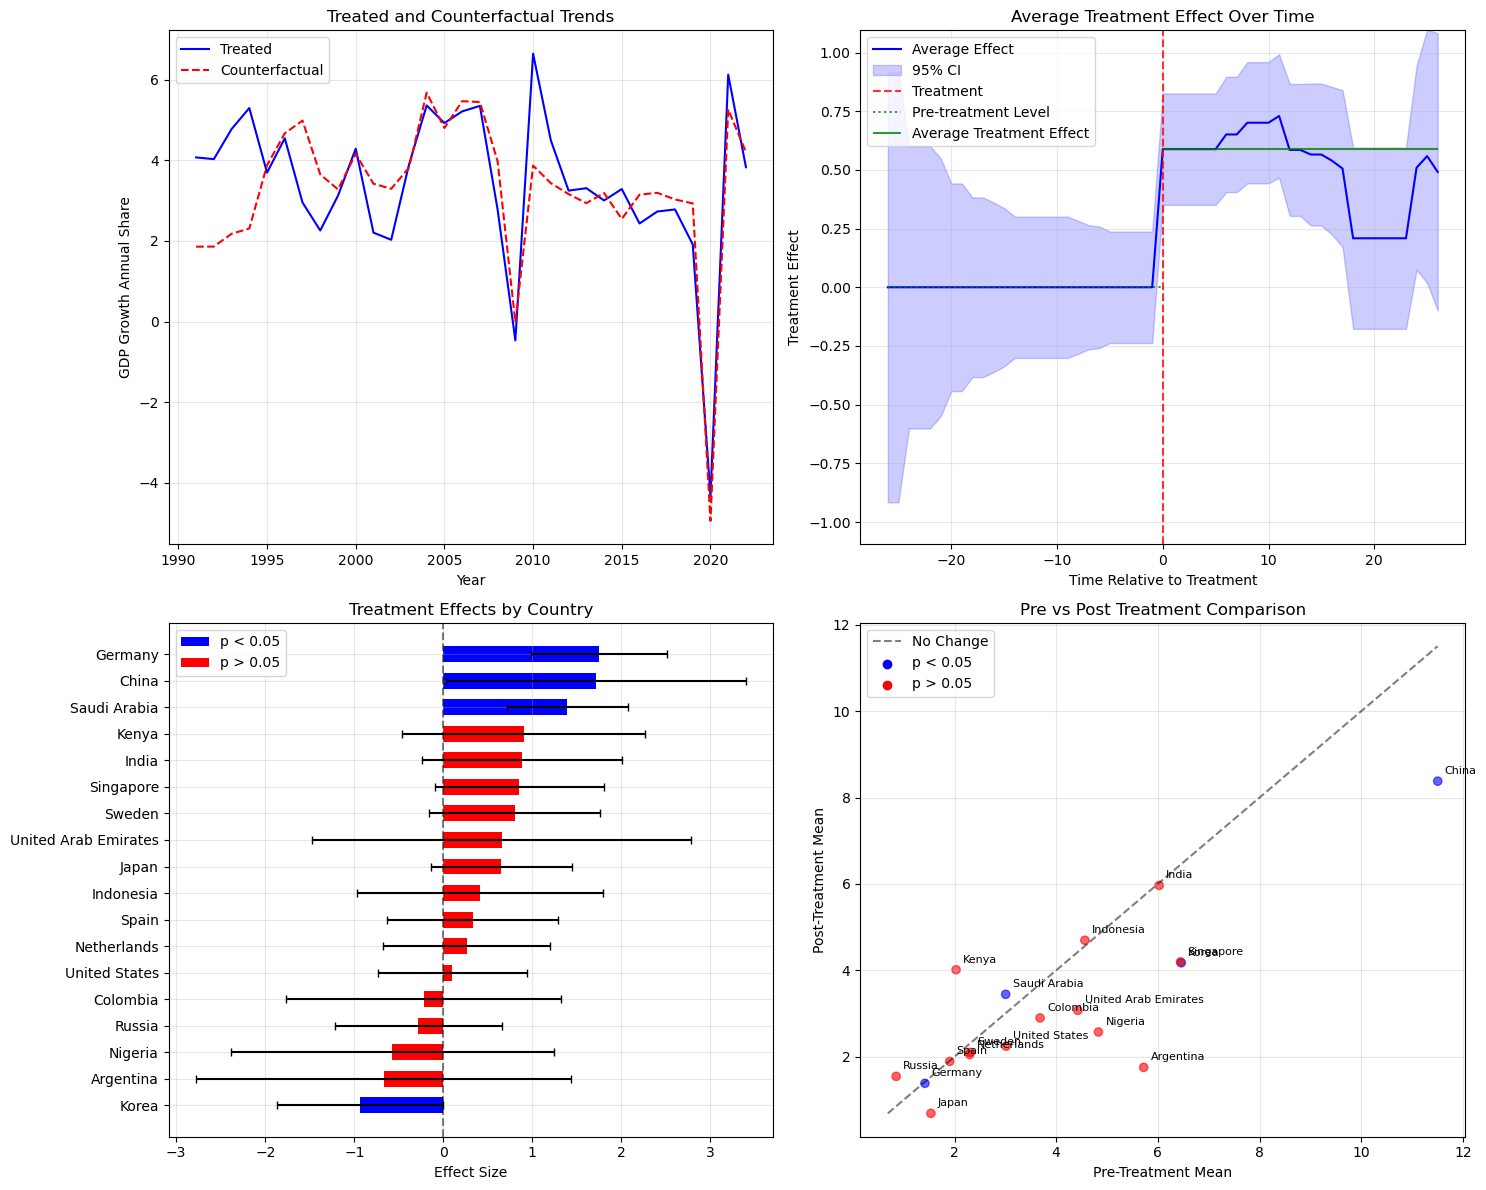

In [48]:
# fig = plot_treatment_visualization(results, data, treatment_periods, gemini_groups, covariates)
fig = plot_treatment_visualization(results, data, treatment_periods, gemini_groups)

# search for covariates

In [42]:
def smart_covariate_search(panel_data, gemini_groups, max_combinations=50, verbose=False):
    """
    Quieter version of smart covariate search
    """
    # First, identify all numeric columns that could be covariates
    numeric_cols = panel_data.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = ['year', 'has_platform', 'gdp_growth_annual_share', 'index']
    potential_covariates = [col for col in numeric_cols if col not in exclude_cols]
    
    if verbose:
        print(f"Found {len(potential_covariates)} potential covariates")
    
    # Group covariates by economic categories
    covariate_groups = {
        'growth': [col for col in potential_covariates if 'growth' in col.lower()],
        'trade': [col for col in potential_covariates if any(term in col.lower() for term in ['trade', 'export', 'import'])],
        'financial': [col for col in potential_covariates if any(term in col.lower() for term in ['fdi', 'invest', 'financial', 'capital', 'gdp'])],
        'social': [col for col in potential_covariates if any(term in col.lower() for term in ['population', 'education', 'health', 'urban'])],
        'environmental': [col for col in potential_covariates if any(term in col.lower() for term in ['emission', 'energy', 'environment'])]
    }
    
    # Feature selection setup
    X = panel_data[potential_covariates].fillna(0)
    y = panel_data['gdp_growth_annual_share'].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Select best features from each group
    selected_covariates = []
    for group_covs in covariate_groups.values():
        if not group_covs:
            continue
            
        X_group = X_scaled[group_covs]
        selector = SelectKBest(f_regression, k=min(2, len(group_covs)))
        selector.fit(X_group, y)
        selected_mask = selector.get_support()
        selected = [cov for cov, selected in zip(group_covs, selected_mask) if selected]
        selected_covariates.extend(selected)
    
    results = []
    
    # Try combinations of different sizes
    for n_covs in range(3, min(6, len(selected_covariates) + 1)):
        if verbose:
            print(f"Testing {n_covs}-covariate combinations...")
            
        cov_combinations = list(combinations(selected_covariates, n_covs))
        np.random.shuffle(cov_combinations)
        
        for covs in cov_combinations[:max_combinations]:
            try:
                analysis_results = run_analysis(panel_data, gemini_groups, list(covs))
                
                if not analysis_results.get('country_effects'):
                    continue
                
                pos_sig = []
                neg_sig = []
                
                for country, effects in analysis_results['country_effects'].items():
                    if effects['p_value'] < 0.05:
                        effect_data = {
                            'country': country,
                            'effect': effects['effect_size'],
                            'p_value': effects['p_value']
                        }
                        
                        if effects['effect_size'] > 0:
                            pos_sig.append(effect_data)
                        else:
                            neg_sig.append(effect_data)
                
                if pos_sig:
                    results.append({
                        'covariates': covs,
                        'n_positive_sig': len(pos_sig),
                        'n_negative_sig': len(neg_sig),
                        'positive_effects': pos_sig,
                        'negative_effects': neg_sig,
                        'avg_positive_effect': np.mean([e['effect'] for e in pos_sig]),
                        'avg_positive_p': np.mean([e['p_value'] for e in pos_sig])
                    })
                    
            except Exception as e:
                if verbose:
                    print(f"Error with covariates {covs}: {str(e)}")
                continue
    
    # Sort results
    results.sort(key=lambda x: (x['n_positive_sig'], x['avg_positive_effect']), reverse=True)
    
    return results

def print_smart_search_results(results, top_n=5):
    """Print the top results from smart covariate search"""
    print("\nTop Covariate Combinations:")
    print("-" * 80)
    
    for i, result in enumerate(results[:top_n], 1):
        print(f"\n{i}. Covariate combination:")
        print("Covariates:", ", ".join(result['covariates']))
        print(f"Number of positive significant effects: {result['n_positive_sig']}")
        print(f"Average positive effect size: {result['avg_positive_effect']:.4f}")
        print(f"Average p-value for positive effects: {result['avg_positive_p']:.4f}")
        
        print("\nPositive significant effects by country:")
        for effect in result['positive_effects']:
            print(f"  {effect['country']}: {effect['effect']:.4f} (p={effect['p_value']:.4f})")
        
        if result['negative_effects']:
            print(f"\nNumber of negative significant effects: {result['n_negative_sig']}")

def run_covariate_search(panel_data, gemini_groups, max_combinations=50):
    """
    Wrapper function to run search with progress bar
    """
    print("Searching for optimal covariate combinations...")
    with tqdm(total=100, desc="Progress") as pbar:
        results = smart_covariate_search(panel_data, gemini_groups, 
                                       max_combinations=max_combinations, 
                                       verbose=False)
        pbar.update(100)
    
    if results:
        print_smart_search_results(results)
    else:
        print("No significant combinations found.")
    
    return results

## get the covariates combination

In [43]:
# Usage:
results = run_covariate_search(panel_data, gemini_groups)

Searching for optimal covariate combinations...


Progress:   0%|                                                                                | 0/100 [00:00<?, ?it/s]


Processing country: Argentina
Treatment year: 1999.0
Control unit: Uruguay
Treated unit observations - Pre: 8, Post: 24
Control unit observations - Pre: 8, Post: 24
Simple DiD estimate: -1.3631
Panel DiD estimate: -4.2186
Standard error: 1.9708
P-value: 0.0365

Processing country: Brazil
Treatment year: 1991.0
Control unit: Colombia
Treated unit observations - Pre: 0, Post: 32
Control unit observations - Pre: 0, Post: 32

Processing country: Chile
Treatment year: 1991.0
Control unit: Australia
Treated unit observations - Pre: 0, Post: 32
Control unit observations - Pre: 0, Post: 32

Processing country: China
Treatment year: 1998.0
Control unit: Thailand
Treated unit observations - Pre: 7, Post: 25
Control unit observations - Pre: 7, Post: 25
Simple DiD estimate: 0.1699
Panel DiD estimate: -0.9295
Standard error: 0.8971
P-value: 0.3044

Processing country: Colombia
Treatment year: 2015.0
Control unit: Ecuador
Treated unit observations - Pre: 24, Post: 8
Control unit observations - Pre:

Progress: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]

Panel DiD estimate: -0.0050
Standard error: 0.0076
P-value: 0.5109

Processing country: Sweden
Treatment year: 2006.0
Control unit: Finland
Treated unit observations - Pre: 15, Post: 17
Control unit observations - Pre: 15, Post: 17
Simple DiD estimate: 1.3103
Panel DiD estimate: -0.0011
Standard error: 0.0029
P-value: 0.6892

Processing country: Thailand
Treatment year: 1991.0
Control unit: Viet Nam
Treated unit observations - Pre: 0, Post: 32
Control unit observations - Pre: 0, Post: 32

Processing country: United Arab Emirates
Treatment year: 2012.0
Control unit: Qatar
Treated unit observations - Pre: 21, Post: 11
Control unit observations - Pre: 21, Post: 11
Simple DiD estimate: 4.8885
Panel DiD estimate: 0.3487
Standard error: 0.2917
P-value: 0.2369

Processing country: United States
Treatment year: 1998.0
Control unit: Canada
Treated unit observations - Pre: 7, Post: 25
Control unit observations - Pre: 7, Post: 25
Simple DiD estimate: -0.9464
Panel DiD estimate: 0.0045
Standard er